In [1]:
import sys
import os
absFilePath = os.path.abspath('example_state_switching.py')
fileDir = os.path.dirname(absFilePath)
parentDir = os.path.dirname(fileDir)

import func_pytorch as functions
from opt_pytorch import FR_algorithm

import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pylab import figure, cm

goal='switch'
bifurcation='low'
switchfromto='lowtohigh' 
noise_strength= 0.0 
realizations=1
noise=0
parameters = functions.set_parameters(goal,bifurcation,parentDir) 

#Set dimensions
T= 400*2 #simulation and control time 
dt=0.1 #time stepsize
tsteps=int(T/dt) #number of timesteps
d=2 #dimension of each FitzHugh-Nagumo node

#set parameters of the cost functional
I_p_in= 0.0005
I_p=torch.zeros((tsteps,parameters['N']))
I_p[int(tsteps-25/dt):]=I_p_in*torch.ones((int(25/dt),parameters['N']))
I_e= 0.1#1.0 
I_s= 0.0


#choose initial condition for control
control=-torch.ones((tsteps,parameters['N']))*0.002
control=control.reshape(tsteps*parameters['N'])

node_ic,target_output=functions.read_node_inis_from_file(bifurcation,switchfromto,fileDir,tsteps,d,dt,parameters)

#make dictionary with all parameters
args = {
    'tsteps':tsteps,
    'dt':dt,
    'd':d,
    'I_p':I_p,
    'I_e':I_e,
    'I_s':I_s,
    'target_output':target_output,
    'node_ic':node_ic,
    'realizations':realizations,
    'noise':noise
    }
args.update(parameters)

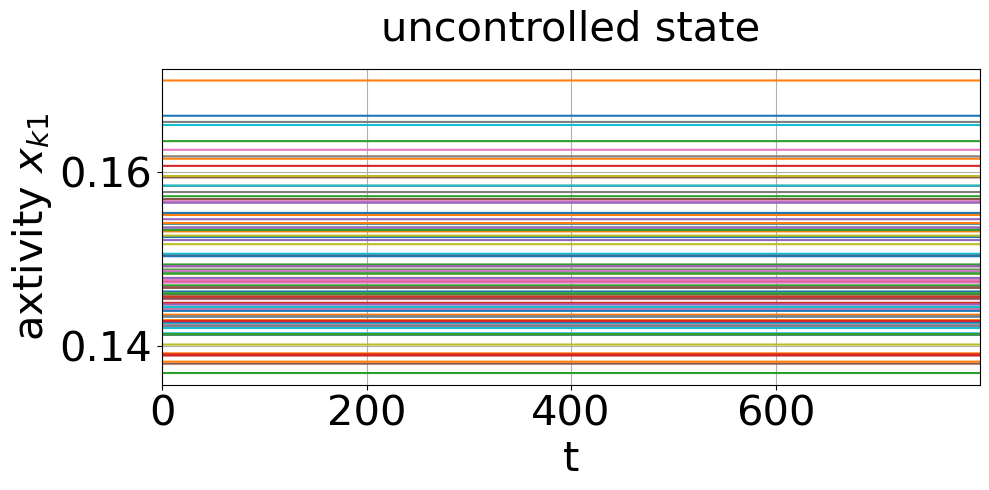

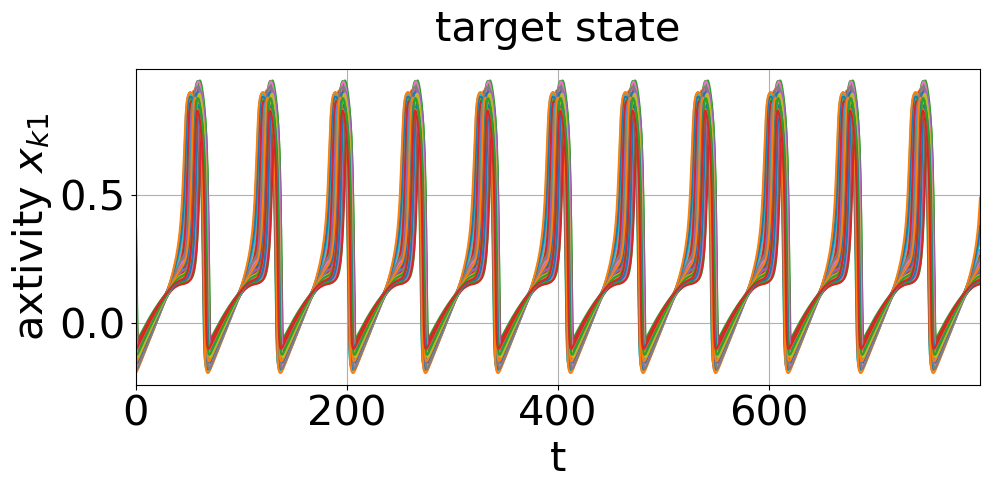

In [2]:
#In this case we want to find an optimal control that induces a switching 
#from an initial low state to a high target state. The uncontrolled state and 
#the target state are plotted:

def create_plot(data,ylabel,title):
    fs=30 #fontsize
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

    # set min and max for scope of y-axis
    minn=torch.min(data)
    maxx=torch.max(data)
    add=(maxx-minn)/25

    im1=ax.plot(np.arange(0,int(T),dt),data)
    ax.set_xlabel('t',size=fs)
    ax.set_ylabel(ylabel,size=fs)
    ax.set_ylim(minn-add,maxx+add)
    ax.set_title(title,size=fs, pad=20)
    ax.tick_params(labelsize=fs)
    ax.grid(True)
    ax.margins(0) # remove default margins (matplotlib verision 2+)

    return fig.tight_layout()

#calculate the uncontrolled state
nocontrol=torch.zeros((tsteps,parameters['N']))
state_uncontrolled=functions.plot_runge_kutta(functions.ODE_FHN_network,nocontrol, **args)

create_plot(state_uncontrolled[:,0,:],'axtivity $x_{k1}$','uncontrolled state')
plt.show()
create_plot(target_output,'axtivity $x_{k1}$','target state')
plt.show()

In [ ]:
#To find the optimal control we define the cost functional and its gradient and start the optimization loop.

#define the functional and its gradient
functional=functions.f_switch
gradient=functions.fprime_switch

#initialize the control loop
iteration=0 
#warnflag=1-> running, warnflag=0->finished, warnflag=3->error
warnflag=1
#start the optmization
result = FR_algorithm(functional, control, gradient, max_k=1000, **args)
control=result[0]
warnflag=result[2]
iteration+=result[4]
print('Code finished after ',iteration,' iterations with warnflag',result[2])